# Майнор "Интеллектуальный анализ данных"

# Курс "Прикладные задачи анализа данных"

## Лабораторная работа №2. RecSys

В рамках данной лабораторной работы вам предлагается решить задачу рекомендательной системы на основе следующих данных:

* **rating.csv** - рейтинги аниме по 10 бальной шкале
* **anime.csv** - описание items

Скачать данные можно [здесь](https://drive.google.com/drive/u/1/folders/1FarHUuqQq4tQSlERB9K8uEfZAZT9tQWv)

# Данные

Данные содержат информацию об предподчтениях 73,516 пользователей в 12,294 аниме. Каждый пользователь может добавить аниме и выставить рейтниг.

Anime.csv

* anime_id - идентификатор аниме (items)
* name - полное название аниме
* genre - категория/категории для аниме (разделены запятой).
* type - тип: movie, TV, OVA, etc.
* episodes - количество эпизодов (для экранизаций)
* rating - средний рейтинг по аниме.
* members - количество членов коммьюнити к аниме

Rating.csv

* user_id - идентификатор пользователя (users)
* anime_id - идентификатор аниме
* rating - рейтинг пользователя по аниме (-1 пользователь смотрел, но не оставил рейтинг).

### ``` Если вычеслительные ресурсы не позволяют решить задачу на всех данных, то необходимо это сделать на "сэмпле" данных (выбрав от 5% ids' для user и item). Этот же подход справедлив и для оценки работы алгоритомв```

In [55]:
import time
import urllib.request
from urllib.error import HTTPError
import scipy as sp


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [56]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
data_anime = pd.read_csv('/content/drive/MyDrive/IAD Lab 2/anime.csv')
data_rating = pd.read_csv('/content/drive/MyDrive/IAD Lab 2/rating.csv')

## Необходимо сделать:

### Задание №1 : Exploratory analysis (2 балла):

* Распределение числа пользователей по количеству взаимодействий
* Распределение числа "айтемов" по количеству взаимодействий
* Распределение числа рейтингов, средних рейтингов по пользователям, по "айтемам"
* и т.д. (бонус)

Проверим данные на наличие пропусков.

In [ ]:
data_anime.isna().sum()

anime_id      0
name          0
genre        62
type         25
episodes      0
rating      230
members       0
dtype: int64

Количество пропусков мало по сравнению с объемом данных, но нам все равно нужно их заполнить.

In [ ]:
data_anime.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12294 entries, 0 to 12293
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   anime_id  12294 non-null  int64  
 1   name      12294 non-null  object 
 2   genre     12232 non-null  object 
 3   type      12269 non-null  object 
 4   episodes  12294 non-null  object 
 5   rating    12064 non-null  float64
 6   members   12294 non-null  int64  
dtypes: float64(1), int64(2), object(4)
memory usage: 672.5+ KB


In [ ]:
data_anime['genre'].mode()

0    Hentai
dtype: object

In [ ]:
data_anime.loc[data_anime.genre.isna(), 'genre'] = 'Hentai'

In [ ]:
data_anime['type'].mode()

0    TV
dtype: object

In [ ]:
data_anime.loc[data_anime.type.isna(), 'type'] = 'TV'

In [ ]:
data_anime.loc[data_anime['rating'].isna(),'rating'] = data_anime['rating'].mean()

In [ ]:
data_anime.loc[data_anime['episodes'] == 'Unknown', 'episodes'] = 0
data_anime['episodes'] = pd.to_numeric(data_anime['episodes'])
data_anime.loc[data_anime['episodes'] == 0, 'episodes'] = round(data_anime['episodes'].mean(),0)

In [ ]:
data_anime.isna().sum()

anime_id    0
name        0
genre       0
type        0
episodes    0
rating      0
members     0
dtype: int64

In [ ]:
data_anime.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12294 entries, 0 to 12293
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   anime_id  12294 non-null  int64  
 1   name      12294 non-null  object 
 2   genre     12294 non-null  object 
 3   type      12294 non-null  object 
 4   episodes  12294 non-null  int64  
 5   rating    12294 non-null  float64
 6   members   12294 non-null  int64  
dtypes: float64(1), int64(3), object(3)
memory usage: 672.5+ KB


In [ ]:
def histogram(dataset, attribute, bins=25, bar_color='#3498db', edge_color='#2980b9', title='Title', xlab='X', ylab='Y', sort_index=False):
    fig, ax = plt.subplots(figsize=(14, 7))
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_title(title, fontsize=24, pad=20)
    ax.set_xlabel(xlab, fontsize=16, labelpad=20)
    ax.set_ylabel(ylab, fontsize=16, labelpad=20)
    
    plt.hist(dataset[attribute], bins=bins, color=bar_color, ec=edge_color, linewidth=2)
    
    plt.xticks(rotation=45)


## [Задание №2 : Оценить разреженность данных по рейтингу (1/2 балла)]

In [ ]:
data_rating[data_rating['rating'] != -1]['rating'].describe()

count    6.337241e+06
mean     7.808497e+00
std      1.572496e+00
min      1.000000e+00
25%      7.000000e+00
50%      8.000000e+00
75%      9.000000e+00
max      1.000000e+01
Name: rating, dtype: float64

In [ ]:
len(data_rating[data_rating['rating'] == -1])/len(data_rating)

0.18896156858107716

In [ ]:
3915/len(data_rating['user_id'].unique())

0.05325443786982249

В целом рейтинг достаточно имеет разнообразные оценки, средняя оценка приближена к 8ми. Около 18% людей не поставили оценки после просмотра

## [Продолжение Задания №1]

Посмотрим на столбчатой диаграмме, какое количество пользователей ставит соответствующие оценки.

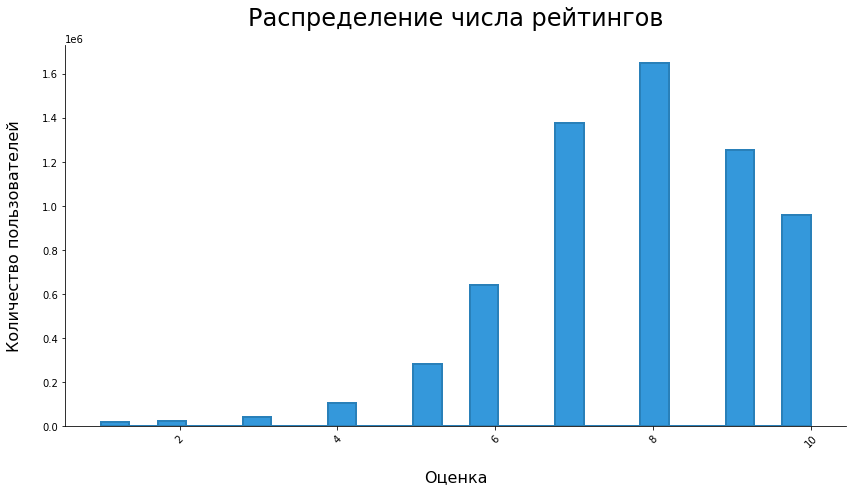

In [ ]:
histogram(data_rating[data_rating['rating'] != -1], 'rating', title='Распределение числа рейтингов', xlab='Оценка', ylab='Количество пользователей')

In [ ]:
best_anime_interaction = data_rating[data_rating['rating'] != -1].pivot_table(['rating'],['anime_id'],aggfunc= ['mean','count']).sort_values([('count','rating')], ascending=False)

In [ ]:
best_with_names = best_anime_interaction.merge(data_anime, on='anime_id')

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


In [ ]:
best_with_names.head(10)

,anime_id,"(mean, rating)","(count, rating)",name,genre,type,episodes,rating,members
0,1535,8.834629,34226,Death Note,"Mystery, Police, Psychological, Supernatural, ...",TV,37,8.71,1013917
1,11757,8.140213,26310,Sword Art Online,"Action, Adventure, Fantasy, Game, Romance",TV,25,7.83,893100
2,16498,8.725741,25290,Shingeki no Kyojin,"Action, Drama, Fantasy, Shounen, Super Power",TV,25,8.54,896229
3,1575,8.927796,24126,Code Geass: Hangyaku no Lelouch,"Action, Mecha, Military, School, Sci-Fi, Super...",TV,25,8.83,715151
4,6547,8.549714,23565,Angel Beats!,"Action, Comedy, Drama, School, Supernatural",TV,13,8.39,717796
5,226,8.064434,23528,Elfen Lied,"Action, Drama, Horror, Psychological, Romance,...",TV,13,7.85,623511
6,20,7.893888,22071,Naruto,"Action, Comedy, Martial Arts, Shounen, Super P...",TV,220,7.81,683297
7,5114,9.322741,21494,Fullmetal Alchemist: Brotherhood,"Action, Adventure, Drama, Fantasy, Magic, Mili...",TV,64,9.26,793665
8,121,8.453356,21332,Fullmetal Alchemist,"Action, Adventure, Comedy, Drama, Fantasy, Mag...",TV,51,8.33,600384
9,2904,9.059837,21124,Code Geass: Hangyaku no Lelouch R2,"Action, Drama, Mecha, Military, Sci-Fi, Super ...",TV,25,8.98,572888


In [ ]:
best_with_names[('count', 'rating')].describe()

count     9926.000000
mean       638.448418
std       1795.944649
min          1.000000
25%          9.000000
50%         57.000000
75%        395.000000
max      34226.000000
Name: (count, rating), dtype: float64

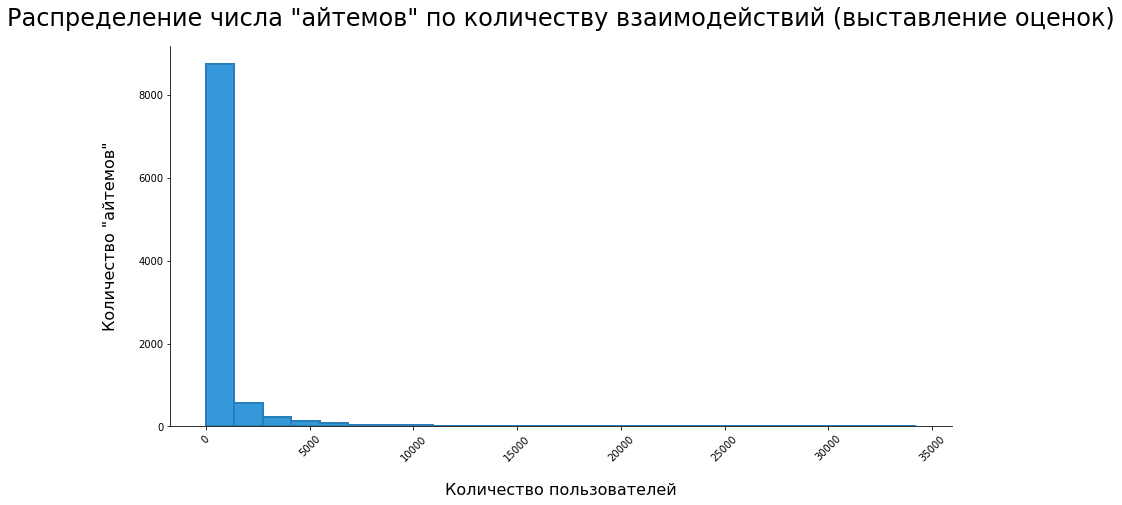

In [ ]:
histogram(best_with_names, ('count', 'rating'), title='Распределение числа "айтемов" по количеству взаимодействий (выставление оценок)', xlab='Количество пользователей', ylab='Количество "айтемов"')

25% "айтемов" имеют менее 9 взаимодействий, 50% "айтемов" - менее 57 взаимодействий, 75% айтемов - менее 395 взаимодействий. Среднее значение высоко (638), благодаря маленькому проценту аниме с активным взаимодействием у пользователей.

In [ ]:
best_user_interaction_minus1 = data_rating[data_rating['rating'] != -1].pivot_table(['rating'],['user_id'],aggfunc= ['mean','count']).sort_values([('count','rating')], ascending=False)
best_user_interaction = data_rating.pivot_table(['rating'],['user_id'],aggfunc= ['mean','count']).sort_values([('count','rating')], ascending=False)

In [ ]:
best_user_interaction

,mean,count
,rating,rating
user_id,,
48766,-1.000000,10227
42635,6.354951,3747
53698,6.546644,2905
57620,7.921170,2702
59643,7.040638,2633
...,...,...
11323,10.000000,1
48775,-1.000000,1


In [ ]:
best_user_interaction_minus1

,mean,count
,rating,rating
user_id,,
42635,6.354951,3747
53698,6.546644,2905
57620,7.964299,2689
59643,7.043693,2632
51693,6.594811,2621
...,...,...
66747,7.000000,1
35463,9.000000,1


In [ ]:
best_user_interaction[('count', 'rating')].describe()

count    73515.000000
mean       106.287656
std        153.086558
min          1.000000
25%         18.000000
50%         57.000000
75%        136.000000
max      10227.000000
Name: (count, rating), dtype: float64

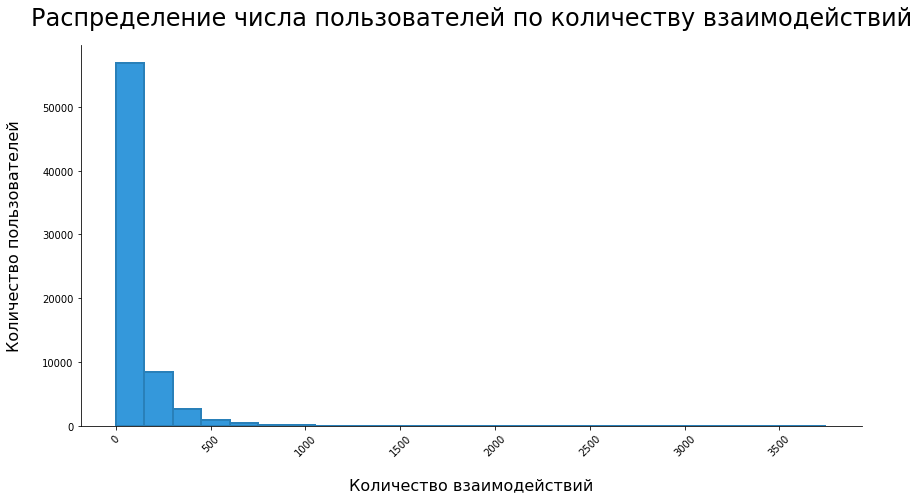

In [ ]:
histogram(best_user_interaction_minus1, ('count', 'rating'), title='Распределение числа пользователей по количеству взаимодействий', xlab='Количество взаимодействий', ylab='Количество пользователей')

25% пользователей посмотрело 18 "айтемов", 50% пользователей - 57 "айтемов", в то время как среднее количество просмотренных "айтемов" составляет 106

### Задание №3 : Разделить данные на тренировочные и валидационные (1/2 балла)

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
train, test = train_test_split(data_rating, test_size=0.3, shuffle=True)

In [ ]:
train

,user_id,anime_id,rating
5264209,49936,2904,9
989613,9201,1117,7
3745124,34996,9366,9
7701903,72381,121,10
7393502,68933,9756,7
...,...,...,...
6708004,61888,28999,6
7729575,72734,16498,-1
6901527,64252,7769,8
3511981,32509,11111,8


### Задание №4 : Решить задачу на основе предложения всем юзерам наиболее популярных item (1 балл)

In [158]:
best20 = list(best_with_names['anime_id'].head(20))

In [159]:
best_with_names.head(20)

,anime_id,"(mean, rating)","(count, rating)",name,genre,type,episodes,rating,members
0,1535,8.834629,34226,Death Note,"Mystery, Police, Psychological, Supernatural, ...",TV,37,8.71,1013917
1,11757,8.140213,26310,Sword Art Online,"Action, Adventure, Fantasy, Game, Romance",TV,25,7.83,893100
2,16498,8.725741,25290,Shingeki no Kyojin,"Action, Drama, Fantasy, Shounen, Super Power",TV,25,8.54,896229
3,1575,8.927796,24126,Code Geass: Hangyaku no Lelouch,"Action, Mecha, Military, School, Sci-Fi, Super...",TV,25,8.83,715151
4,6547,8.549714,23565,Angel Beats!,"Action, Comedy, Drama, School, Supernatural",TV,13,8.39,717796
5,226,8.064434,23528,Elfen Lied,"Action, Drama, Horror, Psychological, Romance,...",TV,13,7.85,623511
6,20,7.893888,22071,Naruto,"Action, Comedy, Martial Arts, Shounen, Super P...",TV,220,7.81,683297
7,5114,9.322741,21494,Fullmetal Alchemist: Brotherhood,"Action, Adventure, Drama, Fantasy, Magic, Mili...",TV,64,9.26,793665
8,121,8.453356,21332,Fullmetal Alchemist,"Action, Adventure, Comedy, Drama, Fantasy, Mag...",TV,51,8.33,600384
9,2904,9.059837,21124,Code Geass: Hangyaku no Lelouch R2,"Action, Drama, Mecha, Military, Sci-Fi, Super ...",TV,25,8.98,572888


In [160]:
best20

[1535,
 11757,
 16498,
 1575,
 6547,
 226,
 20,
 5114,
 121,
 2904,
 4224,
 8074,
 199,
 2167,
 10620,
 9919,
 9253,
 11111,
 2001,
 3588]

In [161]:
rank_table = data_rating.groupby(['user_id'])['anime_id'].apply(lambda x: list(x)).to_frame().reset_index()

In [162]:
rank_table['most_popular'] = 1

In [163]:
rank_table['most_popular'] = rank_table['most_popular'].map(lambda x: best20)

In [164]:
rank_table.head()

,user_id,anime_id,most_popular
0,1,"[20, 24, 79, 226, 241, 355, 356, 442, 487, 846...","[1535, 11757, 16498, 1575, 6547, 226, 20, 5114..."
1,2,"[11771, 12189, 16417]","[1535, 11757, 16498, 1575, 6547, 226, 20, 5114..."
2,3,"[20, 154, 170, 199, 225, 341, 430, 527, 552, 8...","[1535, 11757, 16498, 1575, 6547, 226, 20, 5114..."
3,4,"[6, 72, 121, 150, 166, 205, 226, 857, 1292, 14...","[1535, 11757, 16498, 1575, 6547, 226, 20, 5114..."
4,5,"[6, 15, 17, 18, 20, 22, 24, 30, 45, 47, 57, 63...","[1535, 11757, 16498, 1575, 6547, 226, 20, 5114..."


In [165]:
rank_table['top_20_mp'] = rank_table.apply(lambda x: [int(pred in x['anime_id'][:20]) for pred in x['most_popular'][:20]], axis=1)

In [166]:
rank_table

,user_id,anime_id,most_popular,top_20_mp
0,1,"[20, 24, 79, 226, 241, 355, 356, 442, 487, 846...","[1535, 11757, 16498, 1575, 6547, 226, 20, 5114...","[0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,2,"[11771, 12189, 16417]","[1535, 11757, 16498, 1575, 6547, 226, 20, 5114...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,3,"[20, 154, 170, 199, 225, 341, 430, 527, 552, 8...","[1535, 11757, 16498, 1575, 6547, 226, 20, 5114...","[1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, ..."
3,4,"[6, 72, 121, 150, 166, 205, 226, 857, 1292, 14...","[1535, 11757, 16498, 1575, 6547, 226, 20, 5114...","[1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, ..."
4,5,"[6, 15, 17, 18, 20, 22, 24, 30, 45, 47, 57, 63...","[1535, 11757, 16498, 1575, 6547, 226, 20, 5114...","[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, ..."
...,...,...,...,...
73510,73512,"[60, 98, 101, 120, 199, 226, 339, 355, 552, 65...","[1535, 11757, 16498, 1575, 6547, 226, 20, 5114...","[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, ..."
73511,73513,"[1, 5, 71, 101, 164, 180, 181, 195, 196, 199, ...","[1535, 11757, 16498, 1575, 6547, 226, 20, 5114...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, ..."
73512,73514,[512],"[1535, 11757, 16498, 1575, 6547, 226, 20, 5114...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
73513,73515,"[1, 5, 6, 19, 27, 30, 33, 57, 67, 71, 72, 73, ...","[1535, 11757, 16498, 1575, 6547, 226, 20, 5114...","[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, ..."


(ЗАДАНИЕ №7)

In [169]:
print('20 most popular animes scores \n')
print('MAP@K: ', mean_reciprocal_rank(list(rank_table['top_20_mp'].values)))
print('MRR: ', mean_average_precision(list(rank_table['top_20_mp'].values)))

20 most popular animes scores 

MAP@K:  0.35341399570735466
MRR:  0.26470400189724336


Алгоритм ниже работает, считает, выводит красивый график, но намного дольше (~1,5 часа)

In [ ]:
for user in train['user_id'].unique():
  for item in best20:
    if len(train[train['user_id']==user].loc[train['anime_id']==item]) == 0:
      train.loc[train['user_id']==user, 'rec_pop'] = item
      break

Выходные данные были обрезаны до нескольких последних строк (5000).
See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1763: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1763: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)
/usr/local/li

In [ ]:
rec_popularity = train[~train['rec_pop'].isna()]

In [ ]:
rec_popularity_without_dup = rec_popularity.drop_duplicates('user_id').drop(columns = ['anime_id']).rename(columns = {'rec_pop':'anime_id'}).merge(data_anime, on = 'anime_id')

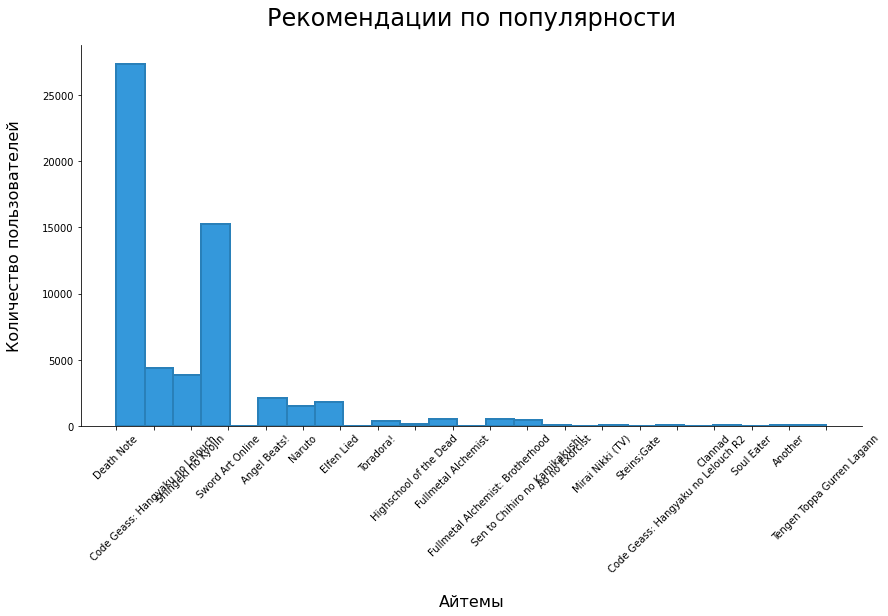

In [ ]:
histogram(rec_popularity_without_dup, 'name', title='Рекомендации по популярности', xlab='Айтемы', ylab='Количество пользователей')

In [ ]:
rec_popularity_without_dup.name.value_counts()

Death Note                            27389
Sword Art Online                      15235
Code Geass: Hangyaku no Lelouch        4387
Shingeki no Kyojin                     3834
Angel Beats!                           2093
Elfen Lied                             1792
Naruto                                 1511
Fullmetal Alchemist                     549
Fullmetal Alchemist: Brotherhood        493
Sen to Chihiro no Kamikakushi           424
Toradora!                               356
Highschool of the Dead                  159
Clannad                                  80
Mirai Nikki (TV)                         62
Ao no Exorcist                           60
Code Geass: Hangyaku no Lelouch R2       55
Another                                  37
Tengen Toppa Gurren Lagann               32
Soul Eater                               26
Steins;Gate                              24
Name: name, dtype: int64

### Задание №5 : Решить задачу на основе коллоборативной фильтрации (2 балла)

* Реализовать один из методов коллоборативной фильтрации SVD, SVD++, ALS, ALS with implicit feedback

ALS

In [ ]:
import pandas as pd
import numpy as np
import os
import json
from sklearn.neighbors import NearestNeighbors
from gensim.test.utils import common_texts
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
%matplotlib inline

In [ ]:
!pip install implicit
from implicit.nearest_neighbours import CosineRecommender

     |████████████████████████████████| 1.1MB 7.6MB/s 
  Created wheel for implicit: filename=implicit-0.4.4-cp37-cp37m-linux_x86_64.whl size=3406425 sha256=379f4b9168c4332767f620b3441b802415709a0021e39878ad0b2c8218694342
  Stored in directory: /root/.cache/pip/wheels/bf/d4/ec/fd4f622fcbefb7521f149905295b2c26adecb23af38aa28217
Successfully built implicit


In [ ]:
from sklearn.preprocessing import MultiLabelBinarizer, OneHotEncoder

In [ ]:
from scipy.sparse import csr_matrix

In [ ]:
from implicit.als import AlternatingLeastSquares

In [ ]:
"""Information Retrieval metrics
Useful Resources:
http://www.cs.utexas.edu/~mooney/ir-course/slides/Evaluation.ppt
http://www.nii.ac.jp/TechReports/05-014E.pdf
http://www.stanford.edu/class/cs276/handouts/EvaluationNew-handout-6-per.pdf
http://hal.archives-ouvertes.fr/docs/00/72/67/60/PDF/07-busa-fekete.pdf
Learning to Rank for Information Retrieval (Tie-Yan Liu)
"""


def mean_reciprocal_rank(rs):
    """Score is reciprocal of the rank of the first relevant item
    First element is 'rank 1'.  Relevance is binary (nonzero is relevant).
    Example from http://en.wikipedia.org/wiki/Mean_reciprocal_rank
    >>> rs = [[0, 0, 1], [0, 1, 0], [1, 0, 0]]
    >>> mean_reciprocal_rank(rs)
    0.61111111111111105
    >>> rs = np.array([[0, 0, 0], [0, 1, 0], [1, 0, 0]])
    >>> mean_reciprocal_rank(rs)
    0.5
    >>> rs = [[0, 0, 0, 1], [1, 0, 0], [1, 0, 0]]
    >>> mean_reciprocal_rank(rs)
    0.75
    Args:
        rs: Iterator of relevance scores (list or numpy) in rank order
            (first element is the first item)
    Returns:
        Mean reciprocal rank
    """
    rs = (np.asarray(r).nonzero()[0] for r in rs)
    return np.mean([1. / (r[0] + 1) if r.size else 0. for r in rs])


def r_precision(r):
    """Score is precision after all relevant documents have been retrieved
    Relevance is binary (nonzero is relevant).
    >>> r = [0, 0, 1]
    >>> r_precision(r)
    0.33333333333333331
    >>> r = [0, 1, 0]
    >>> r_precision(r)
    0.5
    >>> r = [1, 0, 0]
    >>> r_precision(r)
    1.0
    Args:
        r: Relevance scores (list or numpy) in rank order
            (first element is the first item)
    Returns:
        R Precision
    """
    r = np.asarray(r) != 0
    z = r.nonzero()[0]
    if not z.size:
        return 0.
    return np.mean(r[:z[-1] + 1])


def precision_at_k(r, k):
    """Score is precision @ k
    Relevance is binary (nonzero is relevant).
    >>> r = [0, 0, 1]
    >>> precision_at_k(r, 1)
    0.0
    >>> precision_at_k(r, 2)
    0.0
    >>> precision_at_k(r, 3)
    0.33333333333333331
    >>> precision_at_k(r, 4)
    Traceback (most recent call last):
        File "<stdin>", line 1, in ?
    ValueError: Relevance score length < k
    Args:
        r: Relevance scores (list or numpy) in rank order
            (first element is the first item)
    Returns:
        Precision @ k
    Raises:
        ValueError: len(r) must be >= k
    """
    assert k >= 1
    r = np.asarray(r)[:k] != 0
    if r.size != k:
        raise ValueError('Relevance score length < k')
    return np.mean(r)


def average_precision(r):
    """Score is average precision (area under PR curve)
    Relevance is binary (nonzero is relevant).
    >>> r = [1, 1, 0, 1, 0, 1, 0, 0, 0, 1]
    >>> delta_r = 1. / sum(r)
    >>> sum([sum(r[:x + 1]) / (x + 1.) * delta_r for x, y in enumerate(r) if y])
    0.7833333333333333
    >>> average_precision(r)
    0.78333333333333333
    Args:
        r: Relevance scores (list or numpy) in rank order
            (first element is the first item)
    Returns:
        Average precision
    """
    r = np.asarray(r) != 0
    out = [precision_at_k(r, k + 1) for k in range(r.size) if r[k]]
    if not out:
        return 0.
    return np.mean(out)


def mean_average_precision(rs):
    """Score is mean average precision
    Relevance is binary (nonzero is relevant).
    >>> rs = [[1, 1, 0, 1, 0, 1, 0, 0, 0, 1]]
    >>> mean_average_precision(rs)
    0.78333333333333333
    >>> rs = [[1, 1, 0, 1, 0, 1, 0, 0, 0, 1], [0]]
    >>> mean_average_precision(rs)
    0.39166666666666666
    Args:
        rs: Iterator of relevance scores (list or numpy) in rank order
            (first element is the first item)
    Returns:
        Mean average precision
    """
    return np.mean([average_precision(r) for r in rs])


def dcg_at_k(r, k, method=0):
    """Score is discounted cumulative gain (dcg)
    Relevance is positive real values.  Can use binary
    as the previous methods.
    Example from
    http://www.stanford.edu/class/cs276/handouts/EvaluationNew-handout-6-per.pdf
    >>> r = [3, 2, 3, 0, 0, 1, 2, 2, 3, 0]
    >>> dcg_at_k(r, 1)
    3.0
    >>> dcg_at_k(r, 1, method=1)
    3.0
    >>> dcg_at_k(r, 2)
    5.0
    >>> dcg_at_k(r, 2, method=1)
    4.2618595071429155
    >>> dcg_at_k(r, 10)
    9.6051177391888114
    >>> dcg_at_k(r, 11)
    9.6051177391888114
    Args:
        r: Relevance scores (list or numpy) in rank order
            (first element is the first item)
        k: Number of results to consider
        method: If 0 then weights are [1.0, 1.0, 0.6309, 0.5, 0.4307, ...]
                If 1 then weights are [1.0, 0.6309, 0.5, 0.4307, ...]
    Returns:
        Discounted cumulative gain
    """
    r = np.asfarray(r)[:k]
    if r.size:
        if method == 0:
            return r[0] + np.sum(r[1:] / np.log2(np.arange(2, r.size + 1)))
        elif method == 1:
            return np.sum(r / np.log2(np.arange(2, r.size + 2)))
        else:
            raise ValueError('method must be 0 or 1.')
    return 0.


def ndcg_at_k(r, k, method=0):
    """Score is normalized discounted cumulative gain (ndcg)
    Relevance is positive real values.  Can use binary
    as the previous methods.
    Example from
    http://www.stanford.edu/class/cs276/handouts/EvaluationNew-handout-6-per.pdf
    >>> r = [3, 2, 3, 0, 0, 1, 2, 2, 3, 0]
    >>> ndcg_at_k(r, 1)
    1.0
    >>> r = [2, 1, 2, 0]
    >>> ndcg_at_k(r, 4)
    0.9203032077642922
    >>> ndcg_at_k(r, 4, method=1)
    0.96519546960144276
    >>> ndcg_at_k([0], 1)
    0.0
    >>> ndcg_at_k([1], 2)
    1.0
    Args:
        r: Relevance scores (list or numpy) in rank order
            (first element is the first item)
        k: Number of results to consider
        method: If 0 then weights are [1.0, 1.0, 0.6309, 0.5, 0.4307, ...]
                If 1 then weights are [1.0, 0.6309, 0.5, 0.4307, ...]
    Returns:
        Normalized discounted cumulative gain
    """
    dcg_max = dcg_at_k(sorted(r, reverse=True), k, method)
    if not dcg_max:
        return 0.
    return dcg_at_k(r, k, method) / dcg_max

In [75]:
train.head()

,user_id,anime_id,rating
5264209,49936,2904,9
989613,9201,1117,7
3745124,34996,9366,9
7701903,72381,121,10
7393502,68933,9756,7


In [ ]:
id2user = {key: value for key, value in enumerate(train.user_id.unique())}
id2items = {key: value for key, value in enumerate(train.anime_id.unique())} # Get our unique products that were purchased
rating = list(train.rating) # All of our purchases

In [ ]:
user2id  = {value:key for key, value in id2user.items()}
items2id  = {value:key for key, value in id2items.items()}

In [ ]:
rows = train.user_id.map(user2id)
# Get the associated row indices
cols = train.anime_id.map(items2id)
# Get the associated column indices

In [ ]:
rating_sparse = csr_matrix((rating, (rows, cols)), shape=(len(user2id), len(items2id)))
rating_sparse

<72629x10773 sparse matrix of type '<class 'numpy.longlong'>'
	with 5469612 stored elements in Compressed Sparse Row format>

In [ ]:
ALS = AlternatingLeastSquares(num_threads=4, factors = 10,regularization=0.1, use_gpu=False)

In [ ]:
#ALS.fit(rating_sparse.T)

In [57]:
%%time
predict = ALS.recommend_all(rating_sparse, filter_already_liked_items=True)


CPU times: user 15.8 s, sys: 6 s, total: 21.8 s
Wall time: 11.9 s


In [ ]:
ALS.fit(rating_sparse.T)

In [59]:
predict.shape

(72629, 10)

In [60]:
predict

array([[ 376,  921,  280, ...,  572,  282,  513],
       [ 514,    3,   49, ...,  224,   26,  123],
       [2109,  138,  519, ...,  729,  499, 1732],
       ...,
       [  67,  247,    3, ...,    0,  407,   26],
       [  67,  190,  247, ...,   40,  514,    3],
       [2158,   78,  630, ...,  270,  761,  741]], dtype=int32)

In [61]:
test.head()

,user_id,anime_id,rating
6330556,58806,1575,10
7037781,65752,28625,6
7756553,73016,16498,9
7769841,73142,1594,9
728299,6826,165,8


In [62]:
cold_users = [i for i in test.user_id.unique() if i not in train.user_id.unique()]
cold_items = [i for i in test.anime_id.unique() if i not in train.anime_id.unique()]

In [63]:
# flag cold user
test['cold_users'] = test.user_id.map(lambda x: x in cold_users)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [64]:
# flag cold item
test['cold_items'] = test.anime_id.map(lambda x: x in cold_items)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [65]:
test_result = test[(test.cold_items==False)&(test.cold_users==False)]

In [66]:
test

,user_id,anime_id,rating,cold_users,cold_items
6330556,58806,1575,10,False,False
7037781,65752,28625,6,False,False
7756553,73016,16498,9,False,False
7769841,73142,1594,9,False,False
728299,6826,165,8,False,False
...,...,...,...,...,...
3398764,31311,30,8,False,False
4041333,38337,22199,-1,False,False
7505031,70189,10073,-1,False,False
2964909,27528,431,7,False,False


In [67]:
test_result = test_result.groupby(['user_id'])['anime_id'].apply(lambda x: list(x)).reset_index()

In [68]:
test_result['anime_id_pred'] = test_result.user_id.map(lambda x: predict[user2id[x], :])

In [69]:
test_result['anime_id_pred'] = test_result.anime_id_pred.map(lambda x: [id2items[i] for i in x])

In [70]:
test_result['top_3'] = test_result.apply(lambda x: [int(pred in x.anime_id_pred[:3]) for pred in x.anime_id[:3]], axis=1)
test_result['top_5'] = test_result.apply(lambda x: [int(pred in x.anime_id_pred[:5]) for pred in x.anime_id[:5]], axis=1)
test_result['top_10'] = test_result.apply(lambda x: [int(pred in x.anime_id_pred[:10]) for pred in x.anime_id[:10]], axis=1)

(ЗАДАНИЕ №7)

In [71]:
score_results = pd.DataFrame(index=['top_3', 'top_5', 'top_10'], columns=['MRR', 'MAP@K', 'NDCG@k'])

In [72]:
for top in [3, 5, 10]:
    score_results.loc['top_'+str(top), 'MAP@K'] = mean_reciprocal_rank(list(test_result['top_'+str(top)].values))
    score_results.loc['top_'+str(top), 'MRR'] = mean_average_precision(list(test_result['top_'+str(top)].values))
    score_results.loc['top_'+str(top), 'NDCG@k'] = np.mean([ndcg_at_k(i, top) for i in list(test_result['top_'+str(top)].values)])

In [73]:
score_results

,MRR,MAP@K,NDCG@k
top_3,0.110485,0.110763,0.150959
top_5,0.174343,0.177138,0.247641
top_10,0.264896,0.284382,0.382965


### Задание №6 Решить задачу на основе контент-based подхода, выбрав один из методов решения (2 балла):

* На основание векторов с факторизационной матрицы
* При помощи "ембеддингов"  item'ов

На основании векторов с факторизационной матрицы

In [171]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(stop_words='english')
tfidf_matr = tfidf.fit_transform(data_anime['genre'])

tfidf_matr.shape

(12294, 46)

In [172]:
from sklearn.metrics.pairwise import linear_kernel
cosine_sim = linear_kernel(tfidf_matr, tfidf_matr)

In [173]:
inds = pd.Series(data_anime.index, index=data_anime['anime_id']).drop_duplicates()

In [174]:
def get_recommendations(title, cosine_sim=cosine_sim):
    idx = inds[title]
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:11]
    anime_inds = [i[0] for i in sim_scores]
    return data_anime['anime_id'].iloc[anime_inds].iloc[0]

Cousine content based

In [145]:
from implicit.nearest_neighbours import CosineRecommender
cos = CosineRecommender(K = 10)

In [146]:
cos.fit(ALS.item_factors)

In [149]:
ratings = list(train['rating'])
rows = train['user_id'].map(user2id)
cols = train['anime_id'].map(items2id)

rating_sparse_last = csr_matrix((ratings, (rows, cols)), shape=(len(user2id), len(items2id)))*1.0

In [150]:
rating_sparse_last

<72629x10773 sparse matrix of type '<class 'numpy.float64'>'
	with 5469612 stored elements in Compressed Sparse Row format>

In [151]:
def predict_cos(model, user, rating):
    res = model.recommend(user, rating, filter_already_liked_items=True)
    return [i for i, k in res]

test_result['anime_id_pred'] = test_result['user_id']\
    .map(lambda x: predict_cos(cos, user2id[x], rating_sparse_last))

In [153]:
test_result['anime_id_pred'] = test_result['anime_id_pred'].map(lambda x: [id2items[i] for i in x])

In [154]:
test_result['top_20'] = test_result.apply(lambda x: [int(pred in x['anime_id_pred'][:20]) for pred in x['anime_id'][:20]], axis=1)

In [155]:
test_result.head(10)

,user_id,anime_id,anime_id_pred,top_3,top_5,top_10,top_20
0,1,"[10793, 29095, 24455, 9136, 10080, 23321, 1079...","[10620, 11111, 5114, 3588, 6880, 17247, 18277,...","[0, 0, 0]","[0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,2,"[16417, 11771]","[12189, 16001, 14813, 13759, 14227, 9989, 1474...","[0, 0]","[0, 0]","[0, 0]","[0, 0]"
2,3,"[5114, 16918, 1119, 28497, 28171, 7695, 1943, ...","[22319, 121, 6547, 22535, 5114, 9919, 15809, 1...","[1, 0, 0]","[1, 0, 0, 0, 0]","[1, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, ..."
3,4,"[18229, 20931, 17777, 6747, 5341, 9919, 16009,...","[2966, 205, 16890, 21085, 19769, 21067, 20431,...","[0, 0, 0]","[0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 1, 0, 1]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,5,"[20031, 1685, 2248, 14719, 190, 11179, 2116, 3...","[1710, 17, 558, 139, 1842, 12365, 1138, 2961, ...","[0, 0, 0]","[0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
5,6,"[4999, 10897, 6880, 6547, 10719, 228, 12079, 1...","[3713, 317, 2994, 10504, 14027, 1311, 19285, 1...","[0, 0, 0]","[0, 0, 0, 1, 0]","[0, 0, 0, 1, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 0, 0]"
6,7,"[849, 249, 25283, 210, 23427, 26351, 33341, 22...","[25283, 28285, 226, 22877, 14967, 22663, 849, ...","[0, 0, 0]","[0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
7,8,"[10793, 269]","[9919, 3712, 7817, 11319, 12549, 16498, 11111,...","[0, 0]","[0, 0]","[1, 0]","[1, 0]"
8,10,[5114],"[19815, 22199, 27899, 20787, 22535, 30276, 205...",[1],[1],[1],[0]
9,11,"[528, 199, 30, 1002, 5030, 543, 122, 996, 202,...","[523, 996, 1240, 431, 585, 1278, 199, 1119, 11...","[0, 1, 0]","[0, 1, 0, 0, 0]","[0, 1, 1, 0, 0, 0, 0, 0, 0, 0]","[0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, ..."


(ЗАДАНИЕ №7)

In [175]:
print('MAP@K: ', mean_reciprocal_rank(list(test_result['top_20'].values)))
print('MRR: ', mean_average_precision(list(test_result['top_20'].values)))

MAP@K:  0.25860984013609567
MRR:  0.22967019451987042


### Задание №7 Оценить работу алгоритмов выбрав одну из метрик, сделать вывод по результатам работы (2 балла):

* MAP@k
* NDCG@k
* MRR

Было сделано выше для каждого алгоритма сразу двумя метриками.

Достойный результат показала Коллоборативная фильтрация и не очень эффективным методом оказалась рекомендация на основе жанра, поэтому его лучше не применять.
Рекомендация на основе самых популярных - самая лучшая и эффективная практика в соотношении сложность реализациии к результату. Все-такие рекомендовать самые популярные - это всегда беспроигрышная тактика.
